# Lab 3: Ensembles
## Using trees to detect trees

We will be using tree-based ensemble methods on the [Covertype dataset](https://www.openml.org/d/180).
It contains about 100,000 observations of 7 types of trees (Spruce, Pine, Cottonwood, Aspen,...) described by 55 features describing elevation, distance to water, soil type, etc.

In [1]:

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
import seaborn as sns

In [2]:
# Download Covertype data. Takes a while the first time.
covertype = oml.datasets.get_dataset(180)
X, y, _, _ = covertype.get_data(target=covertype.default_target_attribute, dataset_format='array');
classes = covertype.retrieve_class_labels()
features = [f.name for i,f in covertype.features.items()][:-1]

C:\Users\toang\AppData\Local\Temp\ipykernel_6344\1312488982.py:2: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  covertype = oml.datasets.get_dataset(180)
C:\Users\toang\AppData\Local\Temp\ipykernel_6344\1312488982.py:3: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, _ = covertype.get_data(target=covertype.default_target_attribute, dataset_format='array');


In [3]:
classes

['Aspen',
 'Cottonwood_Willow',
 'Douglas_fir',
 'Krummholz',
 'Lodgepole_Pine',
 'Ponderosa_Pine',
 'Spruce_Fir']

In [4]:
features[0:20]

['elevation',
 'aspect',
 'slope',
 'horizontal_distance_to_hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points',
 'wilderness_area1',
 'wilderness_area2',
 'wilderness_area3',
 'wilderness_area4',
 'soil_type_1',
 'soil_type_2',
 'soil_type_3',
 'soil_type_4',
 'soil_type_5',
 'soil_type_6']

To understand the data a bit better, we can use a scatter matrix. From this, it looks like elevation is a relevant feature.
Douglas Fir and Aspen grow at low elevations, while only Krummholz pines survive at very high elevations.

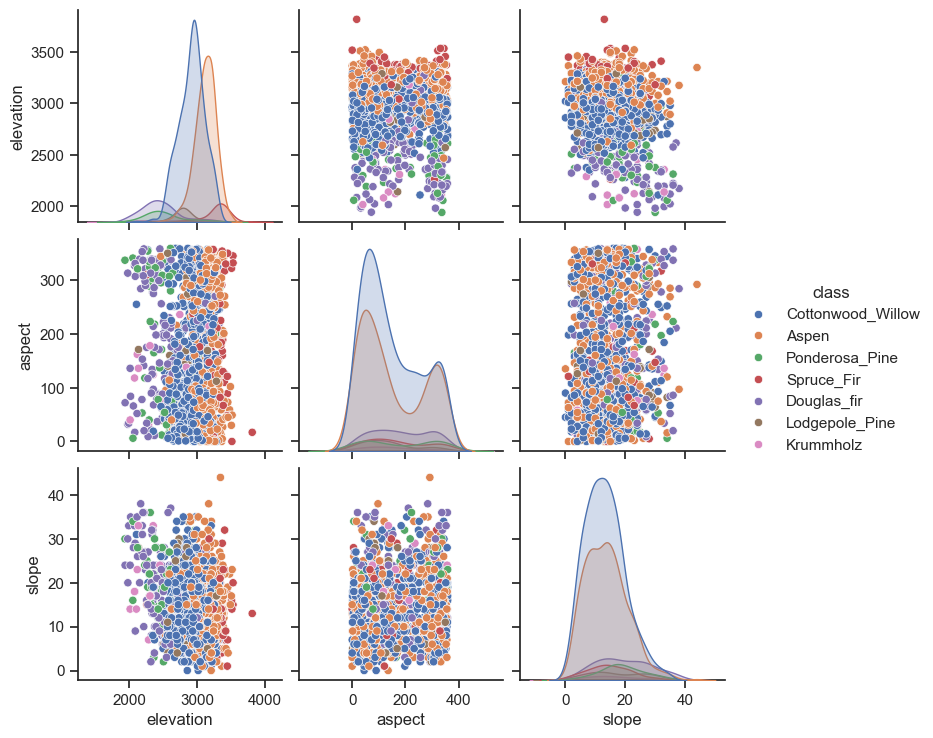

In [5]:
# Using seaborn to build the scatter matrix
# only first 3 columns, first 1000 examples
n_points = 1500
df = pd.DataFrame(X[:n_points,:3], columns=features[:3])
df['class'] = [classes[i] for i in y[:n_points]]
sns.set(style="ticks")
sns.pairplot(df, hue="class");

## Exercise 1: Random Forests
Implement a function `evaluate_RF` that measures the performance of a Random Forest Classifier, using trees
of (max) depth 2,8,32,64, for any number of trees in the ensemble (`n_estimators`).
For the evaluation you should measure accuracy using 3-fold cross-validation.
Use `random_state=1` to ensure reproducibility. Finally, plot the results for at least 5 values of `n_estimators` ranging from 1 to 30. You can, of course, reuse code from earlier labs and assignments. Interpret the results.
You can take a 50% subsample to speed the plotting.

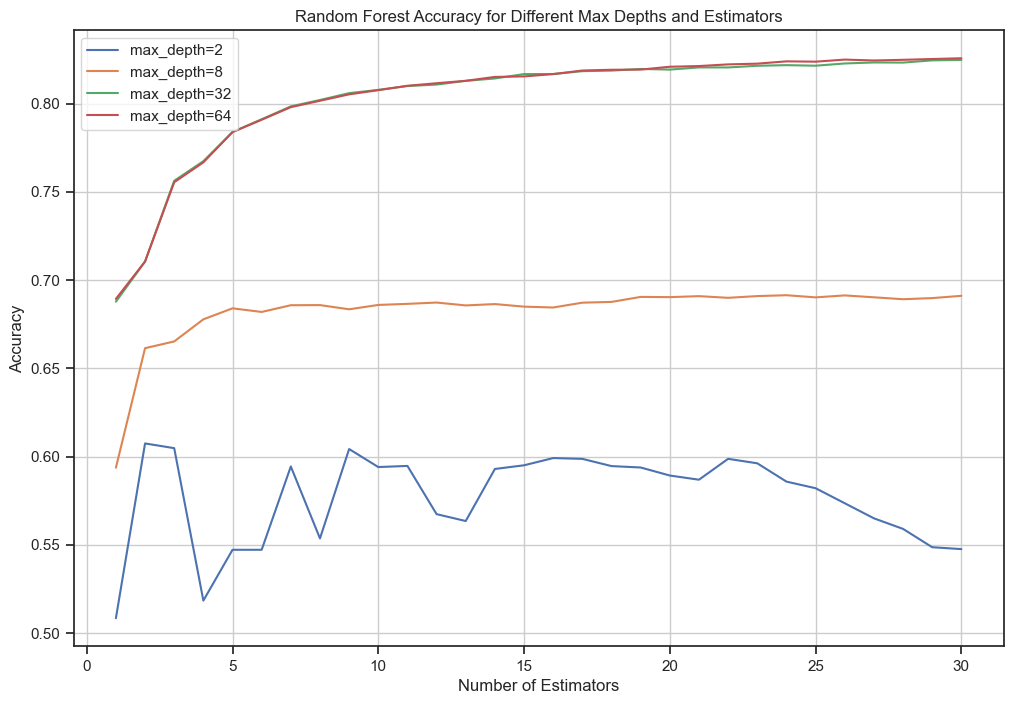

In [7]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Function to evaluate Random Forest with varying max_depth and n_estimators
def evaluate_RF(X, y, max_depths, n_estimators_range, cv=3, random_state=1):
    results = {}
    for max_depth in max_depths:
        accuracies = []
        for n_estimators in n_estimators_range:
            clf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=random_state)
            accuracy = cross_val_score(clf, X, y, cv=cv, scoring='accuracy').mean()
            accuracies.append(accuracy)
        results[max_depth] = accuracies
    return results

# Subsample the data for quicker plotting
X_sub, y_sub = X[:len(X)//2], y[:len(y)//2]

# Define the parameters
max_depths = [2, 8, 32, 64]
n_estimators_range = range(1, 31)

# Evaluate the model
results = evaluate_RF(X_sub, y_sub, max_depths, n_estimators_range)

# Plot the results
plt.figure(figsize=(12, 8))
for max_depth, accuracies in results.items():
    plt.plot(n_estimators_range, accuracies, label=f'max_depth={max_depth}')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy for Different Max Depths and Estimators')
plt.legend()
plt.grid(True)
plt.show()

## Exercise 2: Other measures
Repeat the same plot but now use balanced_accuracy as the evaluation measure. See the [documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score).
Only use the optimal max_depth from the previous question. Do you see an important difference?

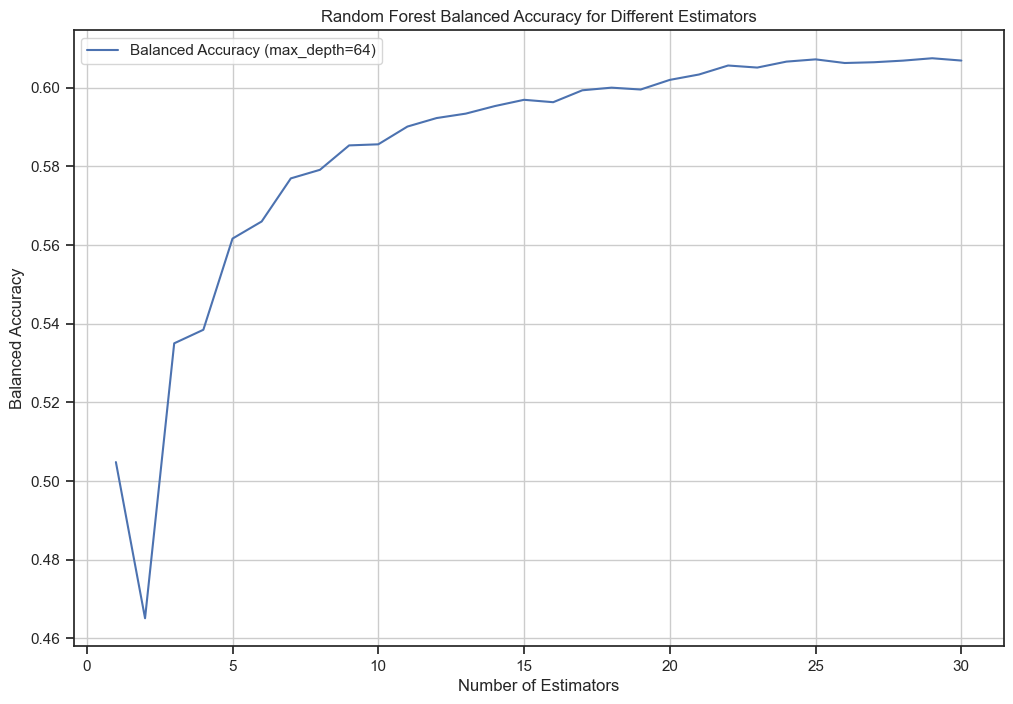

In [9]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score

# Function to evaluate Random Forest with balanced accuracy
def evaluate_RF_balanced(X, y, max_depth, n_estimators_range, cv=3, random_state=1):
    accuracies = []
    for n_estimators in n_estimators_range:
        clf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=random_state)
        balanced_accuracy = cross_val_score(clf, X, y, cv=cv, scoring='balanced_accuracy').mean()
        accuracies.append(balanced_accuracy)
    return accuracies

# Find the optimal max_depth from the previous results
optimal_max_depth = max(results, key=lambda k: max(results[k]))

# Evaluate the model
balanced_results = evaluate_RF_balanced(X_sub, y_sub, optimal_max_depth, n_estimators_range)

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(n_estimators_range, balanced_results, label=f'Balanced Accuracy (max_depth={optimal_max_depth})')
plt.xlabel('Number of Estimators')
plt.ylabel('Balanced Accuracy')
plt.title('Random Forest Balanced Accuracy for Different Estimators')
plt.legend()
plt.grid(True)
plt.show()


## Exercise 3: Feature importance
Retrieve the feature importances according to the (tuned) random forest model. Which feature are most important?

In [10]:
# Train the tuned Random Forest model
tuned_rf = RandomForestClassifier(max_depth=optimal_max_depth, n_estimators=30, random_state=1)
tuned_rf.fit(X_sub, y_sub)

# Retrieve feature importances
feature_importances = tuned_rf.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the most important features
importance_df.head(10)


,Feature,Importance
0,elevation,0.213595
5,Horizontal_Distance_To_Roadways,0.101899
9,Horizontal_Distance_To_Fire_Points,0.095783
3,horizontal_distance_to_hydrology,0.065892
4,Vertical_Distance_To_Hydrology,0.063554
1,aspect,0.062081
7,Hillshade_Noon,0.057937
8,Hillshade_3pm,0.057101
6,Hillshade_9am,0.055092
2,slope,0.046416


## Exercise 4: Feature selection
Re-build your tuned random forest, but this time only using the first 10 features.
Return both the balanced accuracy and training time. Interpret the results.

In [11]:
# Subset the data to the first 10 features
X_sub_10 = X_sub[:, :10]

# Function to evaluate the tuned Random Forest with 10 features
def evaluate_RF_10_features(X, y, max_depth, n_estimators, cv=3, random_state=1):
    clf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=random_state)
    balanced_accuracy = cross_val_score(clf, X, y, cv=cv, scoring='balanced_accuracy').mean()
    return balanced_accuracy

# Evaluate the model
balanced_accuracy_10 = evaluate_RF_10_features(X_sub_10, y_sub, optimal_max_depth, 30)

# Display the result
print(f'Balanced Accuracy with first 10 features: {balanced_accuracy_10}')


Balanced Accuracy with first 10 features: 0.5700920217771527


## Exercise 5: Confusion matrix
Do a standard stratified holdout and generate the confusion matrix of the tuned random forest. Which classes are still often confused?

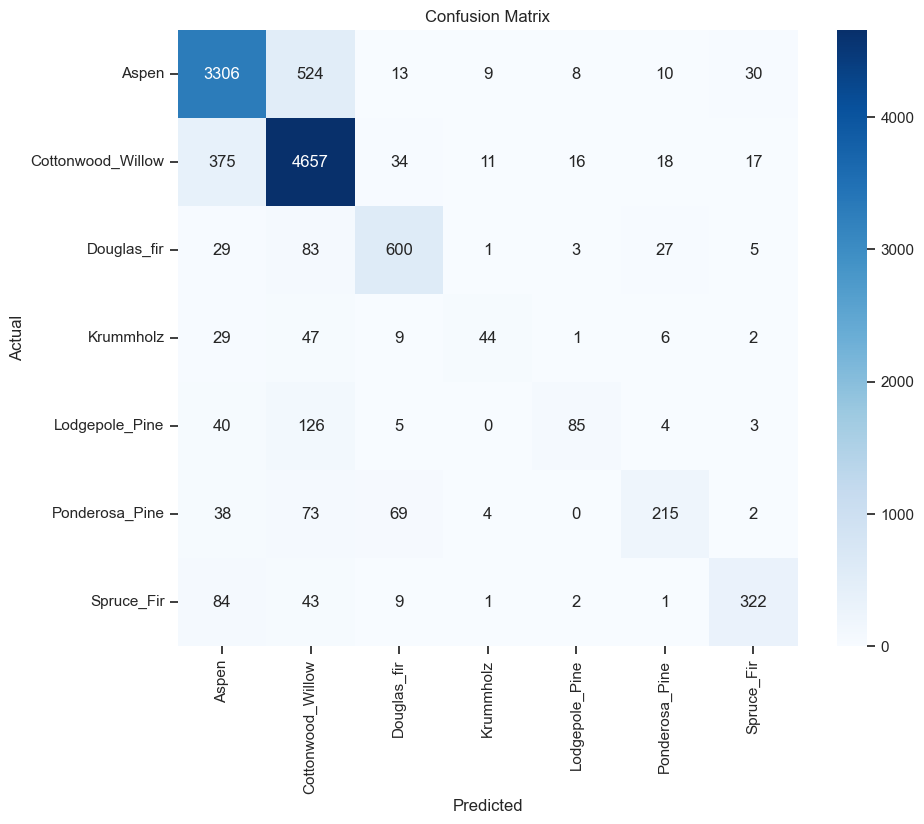

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.2, stratify=y_sub, random_state=1)

# Train the tuned Random Forest model
tuned_rf.fit(X_train, y_train)

# Generate predictions
y_pred = tuned_rf.predict(X_test)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Exercise 6: A second-level model
Build a binary model specifically to correctly choose between the first and the second class.
Select only the data points with those classes and train a new random forest. Do a standard stratified split and plot the resulting ROC curve. Can we still improve the model by calibrating the threshold?

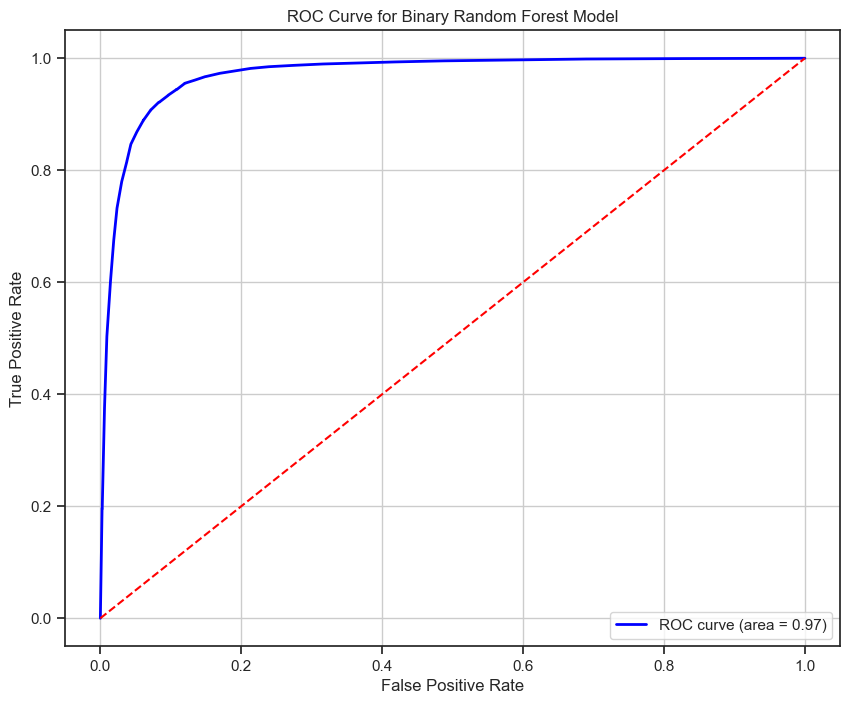

In [13]:
from sklearn.metrics import roc_curve, auc

# Select only the data points with the first two classes
mask = (y == 0) | (y == 1)
X_binary = X[mask]
y_binary = y[mask]

# Split the data
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_binary, y_binary, test_size=0.2, stratify=y_binary, random_state=1)

# Train the Random Forest model
binary_rf = RandomForestClassifier(max_depth=optimal_max_depth, n_estimators=30, random_state=1)
binary_rf.fit(X_train_bin, y_train_bin)

# Generate predictions
y_pred_bin = binary_rf.predict(X_test_bin)
y_prob_bin = binary_rf.predict_proba(X_test_bin)[:, 1]

# Generate the ROC curve
fpr, tpr, _ = roc_curve(y_test_bin, y_prob_bin)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Binary Random Forest Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## Exercise 7: Model calibration
For the trained binary random forest model, plot a calibration curve (see [course notebook](https://ml-course.github.io/engineer/slides_html/03%20-%20Model%20Selection.slides.html#/40)).
Next, try to correct for this using Platt Scaling (or sigmoid scaling).

Probability calibration should be done on new data not used for model fitting. The class [CalibratedClassifierCV](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py) uses a cross-validation generator and estimates for each split the model parameter on the train samples and the calibration of the test samples. The probabilities predicted for the folds are then averaged. Already fitted classifiers can be calibrated by CalibratedClassifierCV via the parameter cv=”prefit”. [Read more](https://scikit-learn.org/stable/modules/calibration.html)

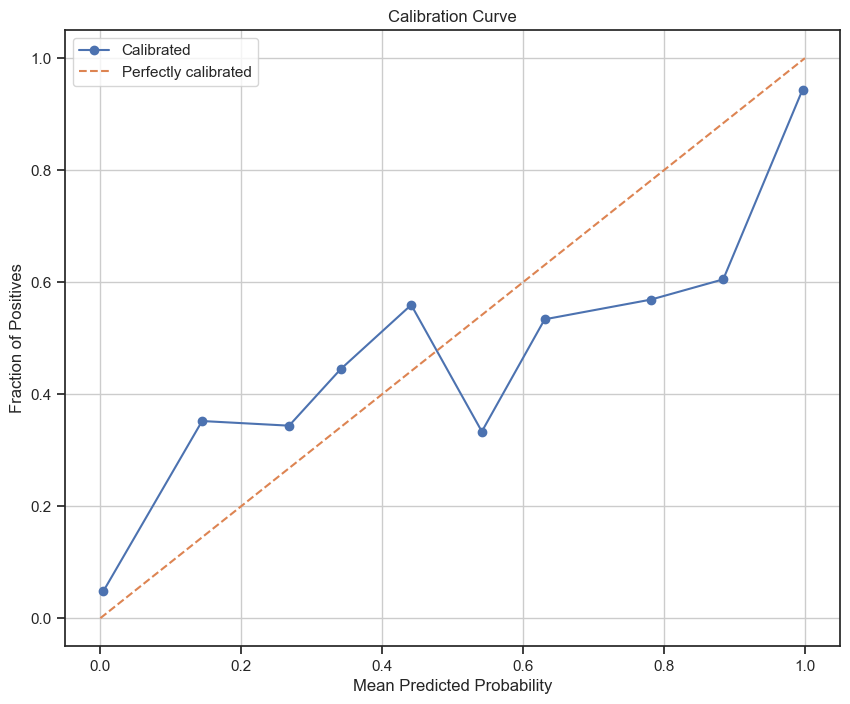

In [15]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Calibrate the Random Forest model using Platt Scaling
calibrated_rf = CalibratedClassifierCV(estimator=binary_rf, method='sigmoid', cv='prefit')
calibrated_rf.fit(X_train_bin, y_train_bin)

# Generate predictions
y_prob_calibrated = calibrated_rf.predict_proba(X_test_bin)[:, 1]

# Plot calibration curve
plt.figure(figsize=(10, 8))
prob_true, prob_pred = calibration_curve(y_test_bin, y_prob_calibrated, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Calibrated')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()


## Exercise 8: Gradient Boosting
Implement a function `evaluate_GB` that measures the performance of `GradientBoostingClassifier` or the `XGBoostClassifier` for
different learning rates (0.01, 0.1, 1, and 10). As before, use a 3-fold cross-validation. You can use a 5% stratified sample of the whole dataset.
Finally plot the results for `n_estimators` ranging from 1 to 100. Run all the GBClassifiers with `random_state=1` to ensure reproducibility.

Implement a function that plots the score of `evaluate_GB` for `n_estimators` = 10,20,30,...,100 on a linear scale.

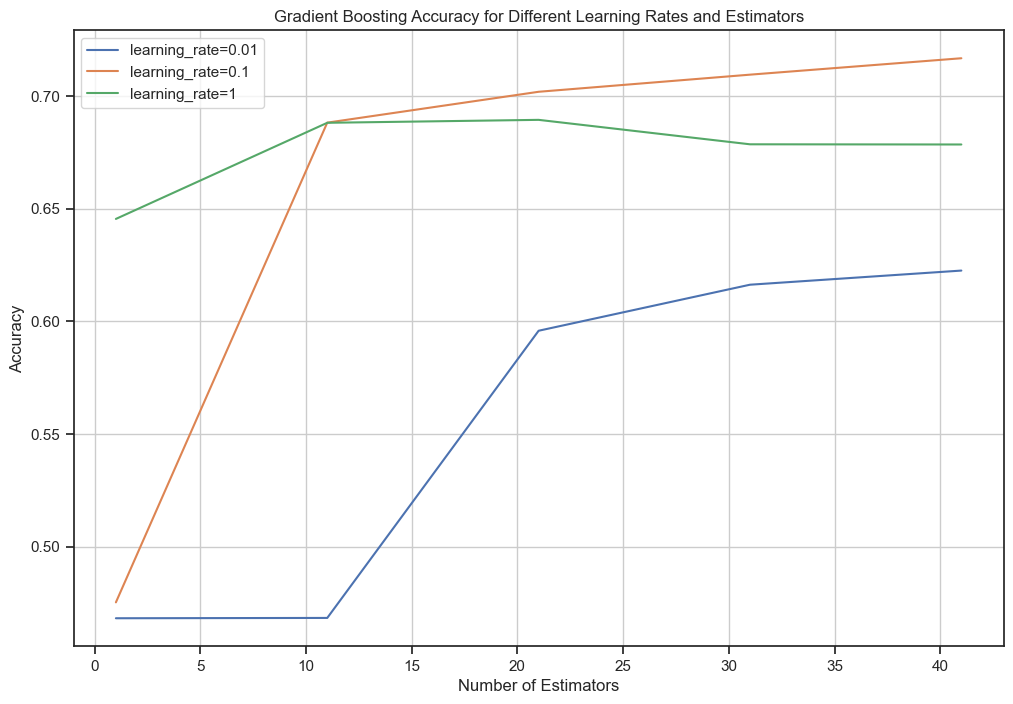

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

# Function to evaluate Gradient Boosting
def evaluate_GB(X, y, learning_rates, n_estimators_range, cv=3, random_state=1):
    results = {}
    for learning_rate in learning_rates:
        accuracies = []
        for n_estimators in n_estimators_range:
            clf = GradientBoostingClassifier(learning_rate=learning_rate, n_estimators=n_estimators, random_state=random_state)
            accuracy = cross_val_score(clf, X, y, cv=cv, scoring='accuracy').mean()
            accuracies.append(accuracy)
        results[learning_rate] = accuracies
    return results

# Define the parameters
learning_rates = [0.01, 0.1, 1]
n_estimators_range = range(1, 51, 10)  # Reduced the range and step size for quicker evaluation

# Subsample the data for quicker plotting (5% stratified sample)
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=1)
for train_index, _ in sss.split(X, y):
    X_sampled, y_sampled = X[train_index], y[train_index]

# Evaluate the model
gb_results = evaluate_GB(X_sampled, y_sampled, learning_rates, n_estimators_range)

# Plot the results
plt.figure(figsize=(12, 8))
for learning_rate, accuracies in gb_results.items():
    plt.plot(n_estimators_range, accuracies, label=f'learning_rate={learning_rate}')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Gradient Boosting Accuracy for Different Learning Rates and Estimators')
plt.legend()
plt.grid(True)
plt.show()
